In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# use TeX rendering and the Times font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
})

df = pd.read_csv('llm_translations.csv')
df

,ModelID,Lang,Throughput,nDCG@20,Size,ScoreC,Rank
0,A8,de,5.01,0.5174,8,0.5324,1.0
1,M24,de,2.33,0.5235,24,0.5305,NaN
2,G4,de,5.38,0.5141,3,0.5303,2.0
3,Q8,de,4.08,0.5165,8,0.5287,3.0
4,G12,de,2.41,0.5202,12,0.5275,NaN
5,Q4,de,5.21,0.5113,4,0.5269,4.0
6,E9,de,4.29,0.5133,9,0.5262,5.0
7,Q30,de,3.15,0.5167,30,0.5261,NaN
8,G27,de,1.18,0.5219,27,0.5255,NaN
9,S12,de,3.57,0.5136,12,0.5243,NaN


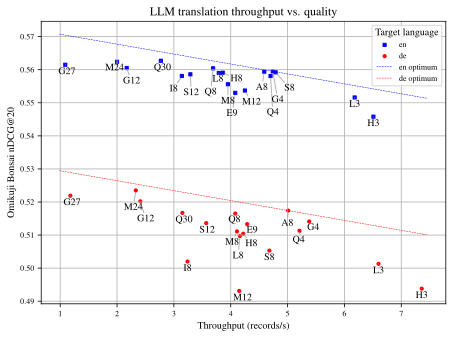

In [43]:
%config InlineBackend.figure_format = 'svg'

# Define colors and markers for each language
colors = {"de": "red", "en": "blue"}
markers = {"de": "o", "en": "s"}

# Create the plot
fig, ax = plt.subplots()
texts = []  # Store text objects for adjustment
original_positions = []  # Store original positions for arrows

# Optimum value lines
slope = -0.003  # How much nDCG can be sacrificed by one unit of throughput
# Generate x values for the lines
x_vals = np.linspace(df["Throughput"].min() - 0.1, df["Throughput"].max() + 0.1, 100)

# de: optimum point (A8, de)
de_opt = df[(df["ModelID"] == "A8") & (df["Lang"] == "de")]
de_x0, de_y0 = de_opt["Throughput"].values[0], de_opt["nDCG@20"].values[0]

# en: optimum point (G4, en)
en_opt = df[(df["ModelID"] == "G4") & (df["Lang"] == "en")]
en_x0, en_y0 = en_opt["Throughput"].values[0], en_opt["nDCG@20"].values[0]

# Equations of the lines
en_y_vals = slope * (x_vals - en_x0) + en_y0
de_y_vals = slope * (x_vals - de_x0) + de_y0

# Function to nudge a label away from the lines
def nudge_label(text, x_vals, en_y_vals, de_y_vals, threshold=0.002):
    x, y = text.get_position()
    en_y_at_x = np.interp(x, x_vals, en_y_vals)
    de_y_at_x = np.interp(x, x_vals, de_y_vals)

    if abs(y - en_y_at_x) < threshold:
        y -= threshold
    if abs(y - de_y_at_x) < threshold:
        y -= threshold
    text.set_position((x, y))

# Plot the data points themselves, separately for de/en language, in different styles
for lang in ('en', 'de'):
    subset = df[df["Lang"] == lang]
    ax.scatter(subset["Throughput"], subset["nDCG@20"], 
               c=colors[lang], marker=markers[lang], label=lang, s=10)

    # Add labels next to each point
    for _, row in subset.iterrows():
        x, y = row["Throughput"], row["nDCG@20"]
        text = ax.text(x, y, row["ModelID"], fontsize=10, ha='center', va='top')
        nudge_label(text, x_vals, en_y_vals, de_y_vals)
        texts.append(text)
        original_positions.append((x, y))


# Add the custom lines
ax.plot(x_vals, en_y_vals, linestyle="--", color="blue", label=f"en optimum", lw=0.5)
ax.plot(x_vals, de_y_vals, linestyle="--", color="red", label=f"de optimum", lw=0.5)

adjust_text(texts,
            expand=(1.2, 1.2),
            target_x=[pos[0] for pos in original_positions],
            target_y=[pos[1] for pos in original_positions],
            arrowprops=dict(arrowstyle='-', color='gray', alpha=0.6),
            only_move='x?y-',
            time_lim=5)

ax.set_xlabel("Throughput (records/s)")
ax.set_ylabel("Omikuji Bonsai nDCG@20")
ax.set_title("LLM translation throughput vs. quality")
ax.legend(title="Target language")
ax.grid(True)
plt.tight_layout()
plt.savefig("fig-llm-translations.pdf", format="pdf")
plt.show()